In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [4]:
# Paths to dataset
train_data_dir = '/kaggle/working/train'
val_data_dir = '/kaggle/working/val'
test_data_dir = '/kaggle/working/test'

# Image properties
img_height, img_width = 224, 224
batch_size = 32
num_classes = 488  # Number of classes

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=50.0,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [5]:
# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 31921 images belonging to 488 classes.
Found 4238 images belonging to 488 classes.
Found 3988 images belonging to 488 classes.


In [6]:
# Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base model layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
predictions = Dense(num_classes, activation='softmax')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [11]:
# Fix steps to avoid running out of data
steps_per_epoch = max(1, len(train_generator))
validation_steps = max(1, len(val_generator))
test_steps = max(1, len(test_generator))

In [12]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=90,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/90


998/998 ━━━━━━━━━━━━━━━━━━━━ 1145s 1s/step - accuracy: 0.0042 - loss: 6.1683 - val_accuracy: 0.0201 - val_loss: 5.5821 - learning_rate: 0.0010
Epoch 2/90
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 136us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/90


998/998 ━━━━━━━━━━━━━━━━━━━━ 1151s 1s/step - accuracy: 0.0107 - loss: 5.7057 - val_accuracy: 0.0293 - val_loss: 5.3148 - learning_rate: 0.0010
Epoch 4/90
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/90
998/998 ━━━━━━━━━━━━━━━━━━━━ 1137s 1s/step - accuracy: 0.0165 - loss: 5.5561 - val_accuracy: 0.0340 - val_loss: 5.2153 - learning_rate: 0.0010
Epoch 6/90
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/90
998/998 ━━━━━━━━━━━━━━━━━━━━ 1134s 1s/step - accuracy: 0.0188 - loss: 5.4677 - val_accuracy: 0.0437 - val_loss: 5.0911 - learning_rate: 0.0010
Epoch 8/90
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 43us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/90
998/998 ━━━━━━━━━━━━━━━━━━━━ 1143s 1s/step - accuracy: 0.0220 - loss: 5.4220 - val_accuracy: 0.0472 - val_loss: 5.0678 - learning_rate: 0.0010
Epoch 10/90
998/998 ━━━━━━━━━━━━━━━━━━

In [13]:
# Save trained model
model.save('MobileNetV2.h5')

# `Test Performance`

In [14]:
# Get final accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# Evaluate on test set
test_loss, final_test_acc = model.evaluate(test_generator, steps=test_steps)

125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 844ms/step - accuracy: 0.0963 - loss: 4.6855


In [15]:
# Print results
print("\nMobileNetV2 Results:")
print(f"Final Train Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.4f}\n")


MobileNetV2 Results:
Final Train Accuracy: 0.0587
Final Validation Accuracy: 0.0941
Final Test Accuracy: 0.0913



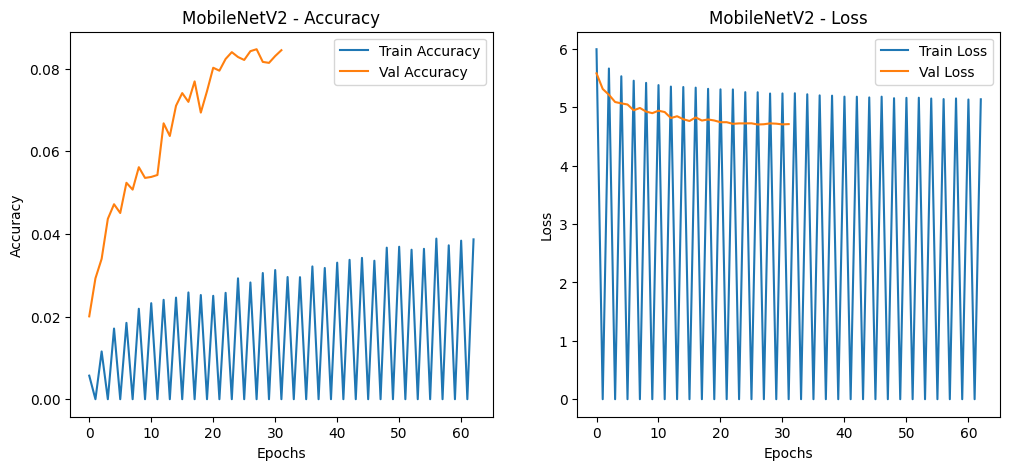

In [16]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MobileNetV2 - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
